In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import math

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print("GPUs:", tf.config.list_physical_devices('GPU'))
tf.config.optimizer.set_jit(True)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
IMAGES_DIR = '/content/drive/Othercomputers/My Mac/Desktop/Stanford Dogs/Images'
img_width, img_height = 224, 224
channels = 3

In [ ]:
filepaths, labels = [], [] # lists for storing the image names and thier labels
images_per_breed = {} # dictionary for checking missing values
for breed_folder in os.listdir(IMAGES_DIR):
  breed_path = os.path.join(IMAGES_DIR, breed_folder) # base_dir + folder_path

  if not os.path.isdir(breed_path):
    continue

  label = breed_folder.split('-', 1)[1]
  images_per_breed[label] = len(os.listdir(breed_path)) # breed : number of images

  for img in os.listdir(breed_path):
    filepaths.append(os.path.join(breed_path, img)) # base_dir + folder_path + image_path
    labels.append(label)

In [ ]:
images_per_breed.keys()

dict_keys(['Bouvier_des_Flandres', 'standard_poodle', 'Welsh_springer_spaniel', 'Norwegian_elkhound', 'Appenzeller', 'Airedale', 'Border_collie', 'wire-haired_fox_terrier', 'affenpinscher', 'Siberian_husky', 'Australian_terrier', 'chow', 'Leonberg', 'English_setter', 'boxer', 'toy_terrier', 'Rhodesian_ridgeback', 'bluetick', 'Norwich_terrier', 'basset', 'bloodhound', 'Great_Dane', 'Afghan_hound', 'dhole', 'basenji', 'German_shepherd', 'Sealyham_terrier', 'Sussex_spaniel', 'Old_English_sheepdog', 'keeshond', 'Shetland_sheepdog', 'komondor', 'Shih-Tzu', 'EntleBucher', 'Irish_wolfhound', 'Lhasa', 'black-and-tan_coonhound', 'Ibizan_hound', 'Irish_water_spaniel', 'German_short-haired_pointer', 'Blenheim_spaniel', 'Scotch_terrier', 'Rottweiler', 'Mexican_hairless', 'toy_poodle', 'pug', 'malinois', 'golden_retriever', 'curly-coated_retriever', 'Maltese_dog', 'miniature_poodle', 'Eskimo_dog', 'briard', 'Bernese_mountain_dog', 'Border_terrier', 'Scottish_deerhound', 'French_bulldog', 'English_s

In [ ]:
# check all labels
assert len(images_per_breed) == 120, (f'There are {len(images_per_breed)}/120 breed folders.')
print('All breed folders are present!')

# check images count
no_images = dict(filter(lambda item: item[1] == 0, images_per_breed.items())) # dict only with images that have no labels
assert len(no_images) == 0, (
    f'There are {len(no_images)}/120 empty breed folders. \nlabels of the missing images: {[item[0] for item in no_images.items()]}'
    )
print('All images are in their correct folders!')
print("There is no missing data!")

All breed folders are present!
All images are in their correct folders!
There is no missing data!


In [ ]:
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

In [ ]:
df['label'].unique()

array(['Bouvier_des_Flandres', 'standard_poodle',
       'Welsh_springer_spaniel', 'Norwegian_elkhound', 'Appenzeller',
       'Airedale', 'Border_collie', 'wire-haired_fox_terrier',
       'affenpinscher', 'Siberian_husky', 'Australian_terrier', 'chow',
       'Leonberg', 'English_setter', 'boxer', 'toy_terrier',
       'Rhodesian_ridgeback', 'bluetick', 'Norwich_terrier', 'basset',
       'bloodhound', 'Great_Dane', 'Afghan_hound', 'dhole', 'basenji',
       'German_shepherd', 'Sealyham_terrier', 'Sussex_spaniel',
       'Old_English_sheepdog', 'keeshond', 'Shetland_sheepdog',
       'komondor', 'Shih-Tzu', 'EntleBucher', 'Irish_wolfhound', 'Lhasa',
       'black-and-tan_coonhound', 'Ibizan_hound', 'Irish_water_spaniel',
       'German_short-haired_pointer', 'Blenheim_spaniel',
       'Scotch_terrier', 'Rottweiler', 'Mexican_hairless', 'toy_poodle',
       'pug', 'malinois', 'golden_retriever', 'curly-coated_retriever',
       'Maltese_dog', 'miniature_poodle', 'Eskimo_dog', 'briard'

In [ ]:
# split the dataframe into train and test sets with a ration of 80/20
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'], # keep the disribution between train and test sets.
    random_state=42
)

In [ ]:
# Build the class‐name list and mapping
class_names    = sorted(train_df['label'].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}

# Add an integer column for each split
train_df['label_idx'] = train_df['label'].map(label_to_index)
val_df  ['label_idx'] = val_df  ['label'].map(label_to_index)

#Number of classes
num_classes = len(class_names)   # should be 120 in your case

In [ ]:
def make_dataset(df, batch_size, num_classes, training=True):
    """
    Builds a tf.data.Dataset from a DataFrame with columns
    'filepath' and 'label_idx' (integer class index).

    Args:
      df: pd.DataFrame with 'filepath' and 'label_idx' columns.
      batch_size: int
      num_classes: int, number of distinct classes for one-hot.
      training: bool, if True shuffles the dataset.

    Returns:
      A tf.data.Dataset yielding (image, one-hot label) batches.
    """
    # Get file paths and integer labels
    paths  = df['filepath'].values
    labels = df['label_idx'].values.astype('int32')

    # Build initial Dataset
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Define load & preprocess function
    def _load_and_preprocess(path, label):
        # Read image from disk
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width]) / 255.0

        if training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
        # Convert label to one-hot
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    # Apply preprocessing in parallel
    ds = ds.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # (Optional) Shuffle if training
    if training:
        ds = ds.shuffle(buffer_size=1024)

    # Batch, cache in RAM, and prefetch for performance
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [ ]:
def build_base(network):
  base = network(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  base.trainable = False
  return base

def build_head(base):
  x = GlobalAveragePooling2D()(base.output)

  x = Dense(512, kernel_regularizer=l2(0.0001))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.5)(x)

  x = Dense(256, kernel_regularizer=l2(0.0001))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.5)(x)

  head = Dense(120, activation='softmax')(x)
  return Model(inputs=base.input, outputs=head)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
lr = 1e-04
batch_size = 32

In [ ]:
results = []
base_networks = {
    'Xception': Xception,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2
}

for base_name, base_network in base_networks.items():
  tf.keras.backend.clear_session()

  train_ds = make_dataset(train_df, batch_size, num_classes, training=True)
  val_ds   = make_dataset(val_df,   batch_size, num_classes, training=False)

  steps_per_epoch = math.ceil(len(train_df) / batch_size)
  validation_steps = math.ceil(len(val_df) / batch_size)

  model = build_head(build_base(base_network))

  model.compile(
    optimizer=Adam(learning_rate=lr),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
  )

  print(f'Training Network with Base: {base_name}')
  print('-'*40)

  history = model.fit(
      train_ds,
      epochs=10,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_ds,
      validation_steps=validation_steps,
      )

  results.append({
      'base': base_name,
      'weights': model.get_weights(),
      'config': model.to_json(),
      'history': history.history
  })

Training Network with Base: Xception
----------------------------------------
Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 47s 69ms/step - accuracy: 0.1045 - loss: 4.6062 - val_accuracy: 0.7456 - val_loss: 2.3122
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5279 - loss: 2.6938 - val_accuracy: 0.7843 - val_loss: 1.6485
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6527 - loss: 2.1008 - val_accuracy: 0.7998 - val_loss: 1.4105
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7045 - loss: 1.8115 - val_accuracy: 0.8034 - val_loss: 1.3004
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7332 - loss: 1.6400 - val_accuracy: 0.8069 - val_loss: 1.2477
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7490 - loss: 1.5398 - val_accuracy: 0.8086 - val_loss: 1.2186
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7667 - loss: 1.4581 - val_accuracy: 0.8090 - val_loss: 1.2035
Epoch 8/10
5

In [ ]:
def comp_dash(results):
  records_loss = []
  for result in results:
    for ep, val_loss in enumerate(result['history']['val_loss'], start=1):
      records_loss.append({
          'Epoch': ep,
          'Validation Loss': val_loss,
          'Model': result['base']
      })
  df_loss = pd.DataFrame(records_loss)

  sns.set_style('darkgrid')
  fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

  sns.lineplot(data=df_loss, x='Epoch', y='Validation Loss',
              hue='Model', palette='Set2', marker='o', ax=ax)
  ax.set_title('Validation Loss per Epoch')
  ax.legend(title='Model',
            fontsize='small',
            loc='upper right',
            bbox_to_anchor=(1.05, 1))

  plt.tight_layout()
  plt.show()

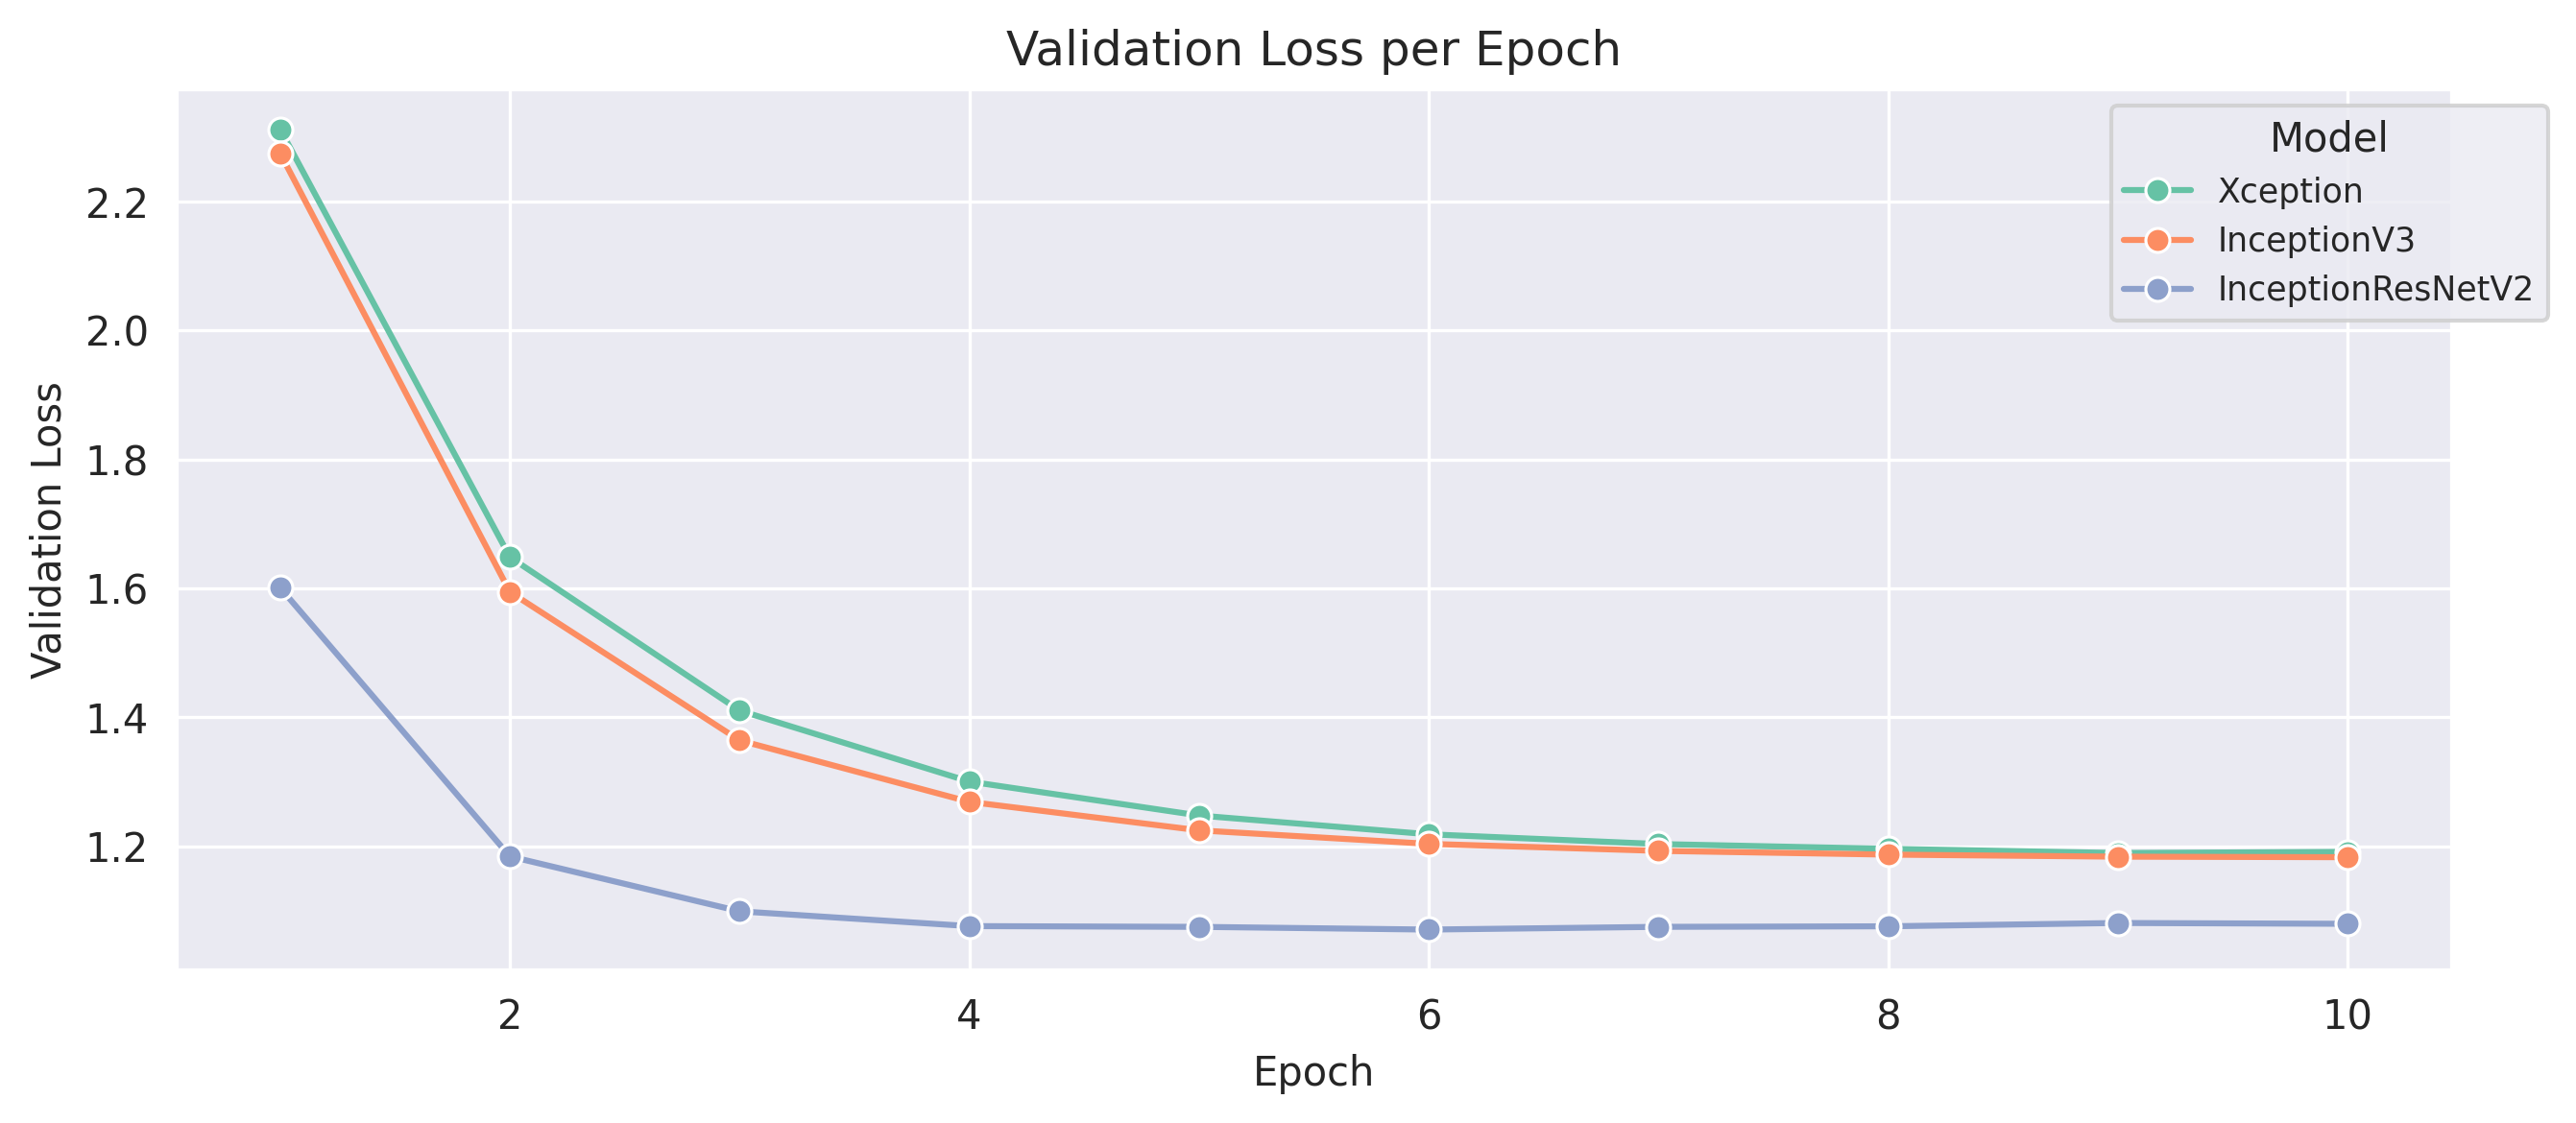

In [ ]:
comp_dash(results)

In [ ]:
from tensorflow.keras.models import model_from_json
entry = next(result for result in results if result['base'] == 'InceptionResNetV2')
inceptionresnet = model_from_json(entry['config'])
inceptionresnet.set_weights(entry['weights'])

In [ ]:
# add early-stopping to prevent overfit at high epoch:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=2
)

# Save best model weights:
checkpoint1 = ModelCheckpoint(
    'model_rs_results.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
train_ds = make_dataset(train_df, batch_size, num_classes, training=True)
val_ds = make_dataset(val_df,   batch_size, num_classes, training=False)

steps_per_epoch = math.ceil(len(train_df) / batch_size)
validation_steps = math.ceil(len(val_df) / batch_size)

history = inceptionresnet.fit(
    train_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8437 - loss: 1.1728
Epoch 1: val_loss improved from inf to 1.08429, saving model to model.weights.h5
515/515 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.8437 - loss: 1.1728 - val_accuracy: 0.8474 - val_loss: 1.0843
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8435 - loss: 1.1532
Epoch 2: val_loss improved from 1.08429 to 1.08271, saving model to model.weights.h5
515/515 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8435 - loss: 1.1532 - val_accuracy: 0.8484 - val_loss: 1.0827
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8459 - loss: 1.1375
Epoch 3: val_loss did not improve from 1.08271
515/515 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8459 - loss: 1.1375 - val_accuracy: 0.8516 - val_loss: 1.0833
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8439 - loss: 1.1270
Epoch 4: val_loss did not improve from 1.08271
515/515 ━━━━━━━━━━━━━━━━━━━━ 19s 3

In [ ]:
def plot_acc(history, save_epoch=None, save_path=None):
  sns.set_style('darkgrid')
  epochs = range(1, len(history['accuracy']) + 1)

  plt.figure(figsize=(9, 4), dpi=300)

  if save_epoch:
    plt.axvline(x=save_epoch, linestyle='--', color='gray', alpha=0.6, label='Model Saved')

  sns.lineplot(x=epochs, y=history['accuracy'],
                label='Training', marker='o')
  sns.lineplot(x=epochs, y=history['val_accuracy'],
                label='Validation', marker='o')

  plt.title('Training vs. Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.tight_layout()

  if save_path:
    plt.savefig(save_path)

  plt.show()

In [ ]:
# Don't run more than once
concat_hist = {k : [] for k in history.history.keys()}

for key in concat_hist.keys():
  concat_hist[key].extend(entry['history'][key])
  concat_hist[key].extend(history.history[key])

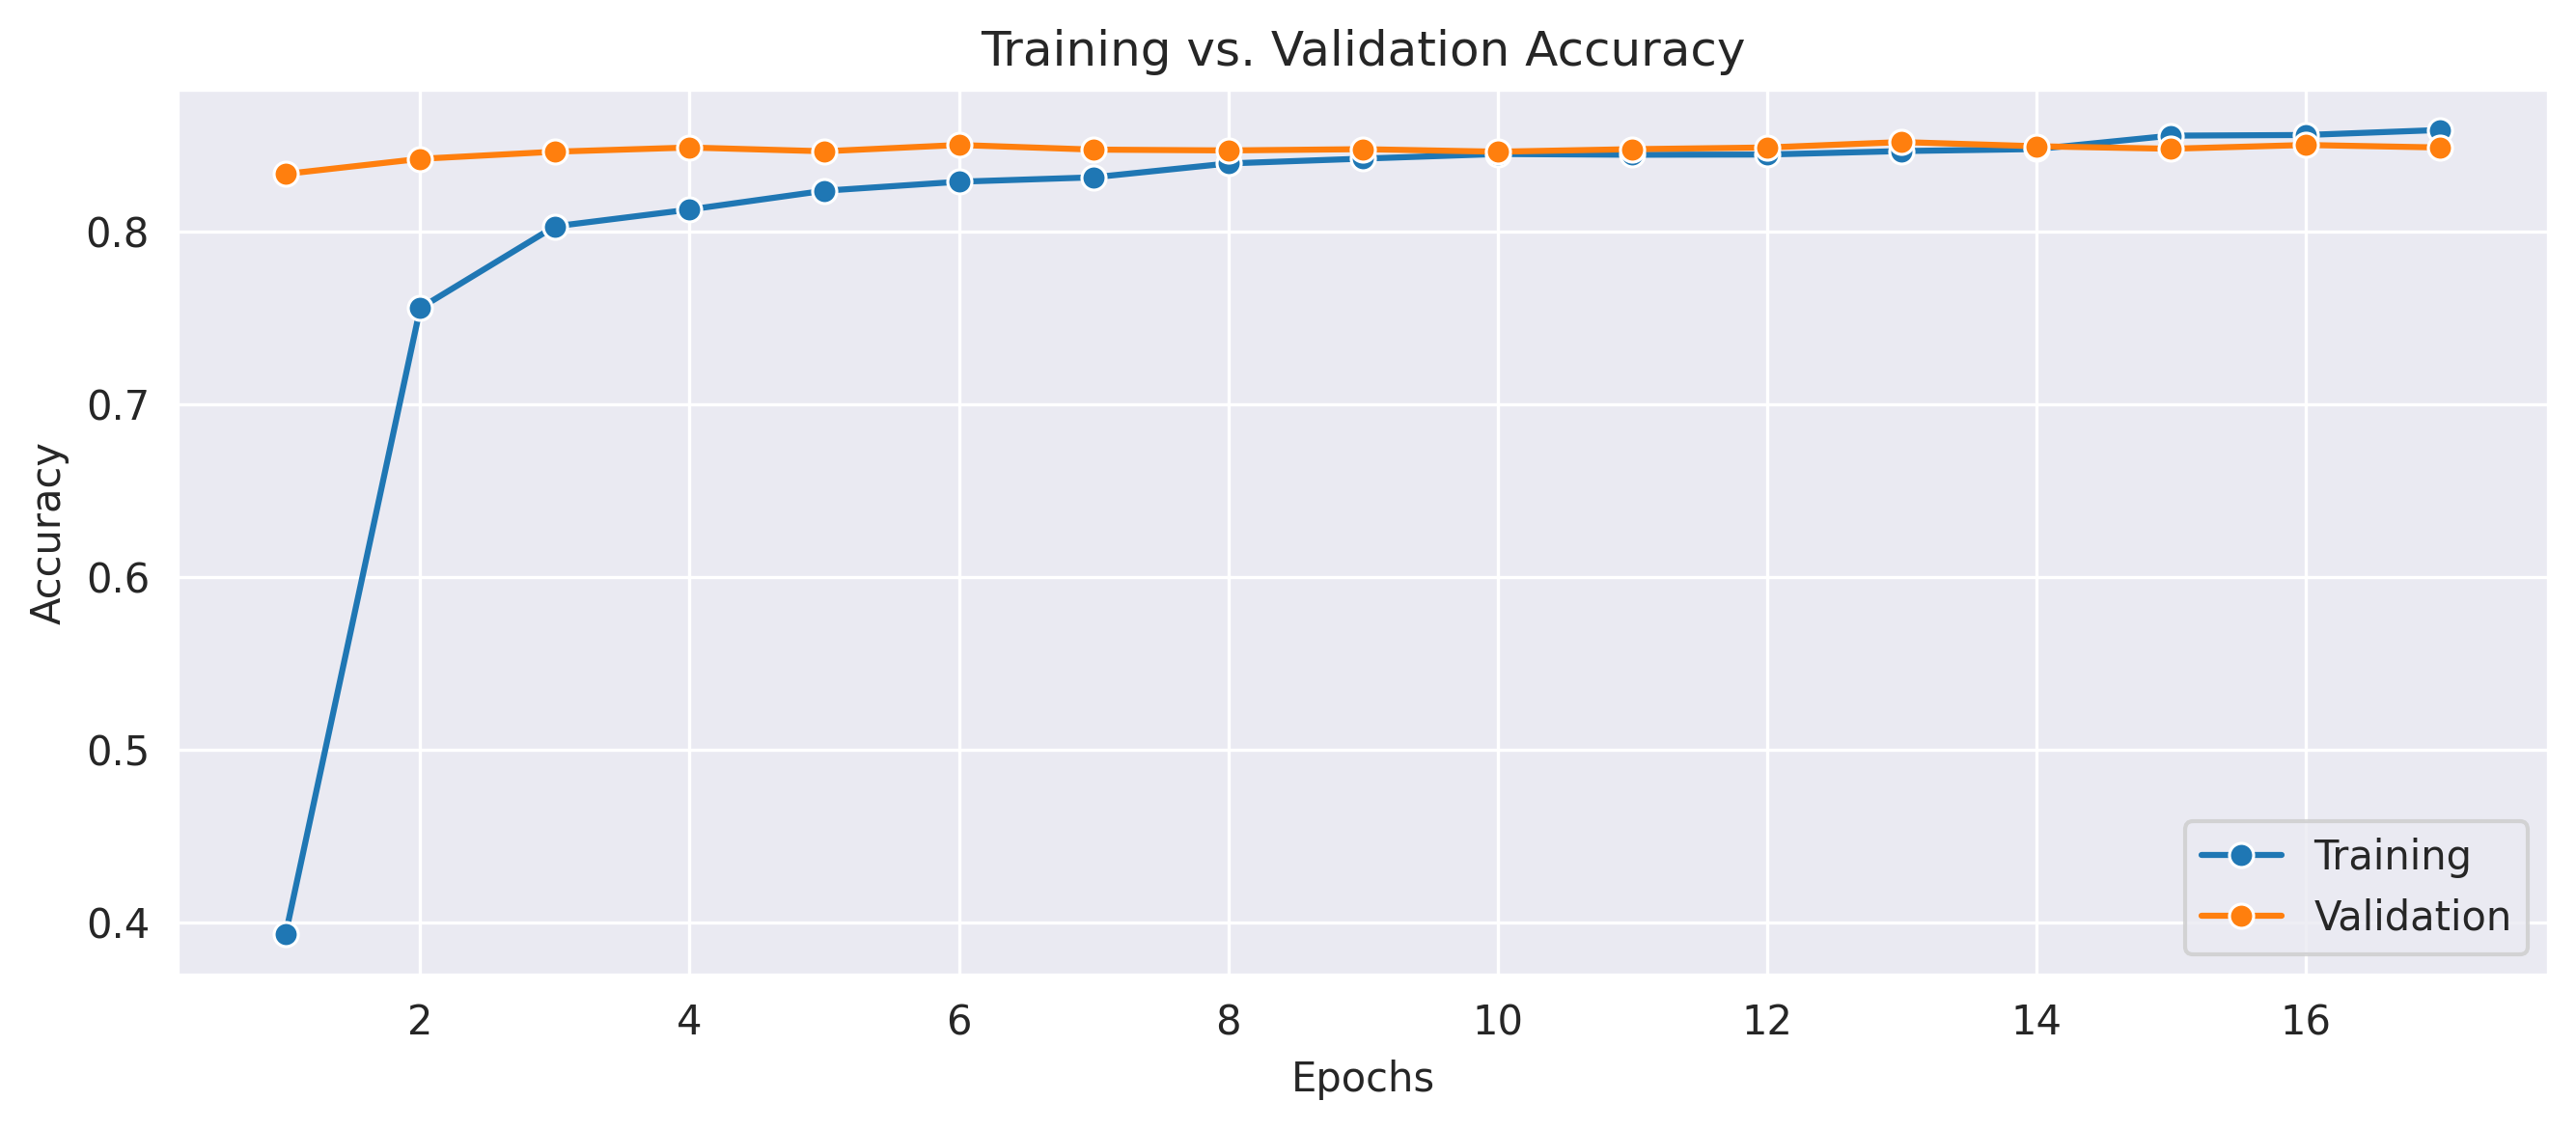

In [ ]:
plot_acc(concat_hist)

#Fine Tuning the Base of The Model

In [ ]:
trainable_layers = 75
lr = 1e-6
batch_size = 64
epochs = 10

In [ ]:
prev_name = 'model_rs_results.weights.h5'
HOME_PATH = '/content/drive/MyDrive/Machine Learning Projects/Dog Breed classification project/'

In [ ]:
log_name = f'model_ft_results(layers={trainable_layers}, lr={lr}).keras'

early_stop2 = EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=1e-4,
    restore_best_weights=False,
    verbose=2
)

checkpoint2 = ModelCheckpoint(
    HOME_PATH + log_name,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=2
)

lr_reduce_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=2
)

In [ ]:
train_ds = make_dataset(train_df, batch_size, num_classes, training=True)
val_ds = make_dataset(val_df,   batch_size, num_classes, training=False)

steps_per_epoch = math.ceil(len(train_df) / batch_size)
validation_steps = math.ceil(len(val_df) / batch_size)

In [ ]:
inceptionresnet = build_head(build_base(InceptionResNetV2))
inceptionresnet.load_weights(HOME_PATH + prev_name)

for layer in inceptionresnet.layers[-trainable_layers:]:
  layer.trainable = True

inceptionresnet.compile(
  optimizer=Adam(learning_rate=lr),
  loss=CategoricalCrossentropy(label_smoothing=0.05),
  metrics=['accuracy']
)

print(f'Unfrozen Layers (top) = {trainable_layers}')
print('-'*30)

fine_tuning_history = inceptionresnet.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[early_stop, lr_reduce_on_plateau]
)

Unfrozen Layers (top) = 75
------------------------------
Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 109s 123ms/step - accuracy: 0.8208 - loss: 1.2730 - val_accuracy: 0.8472 - val_loss: 1.0965 - learning_rate: 1.0000e-06
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8259 - loss: 1.2324 - val_accuracy: 0.8494 - val_loss: 1.0905 - learning_rate: 1.0000e-06
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8232 - loss: 1.2220 - val_accuracy: 0.8477 - val_loss: 1.0869 - learning_rate: 1.0000e-06
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8325 - loss: 1.1974 - val_accuracy: 0.8484 - val_loss: 1.0843 - learning_rate: 1.0000e-06
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8379 - loss: 1.1814 - val_accuracy: 0.8491 - val_loss: 1.0832 - learning_rate: 1.0000e-06
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8373 - loss: 1.1764 - val_accuracy: 0.8491 - val_loss: 1.0821 - learning_rate: 1.0

In [ ]:
inceptionresnet.save(HOME_PATH + log_name)

In [ ]:
plot_name = f'training_val_accuracy(layers={trainable_layers}, lr={lr}).png'
plot_path = HOME_PATH + plot_name
save_epoch = np.argmin(fine_tuning_history.history['val_accuracy']) + 1

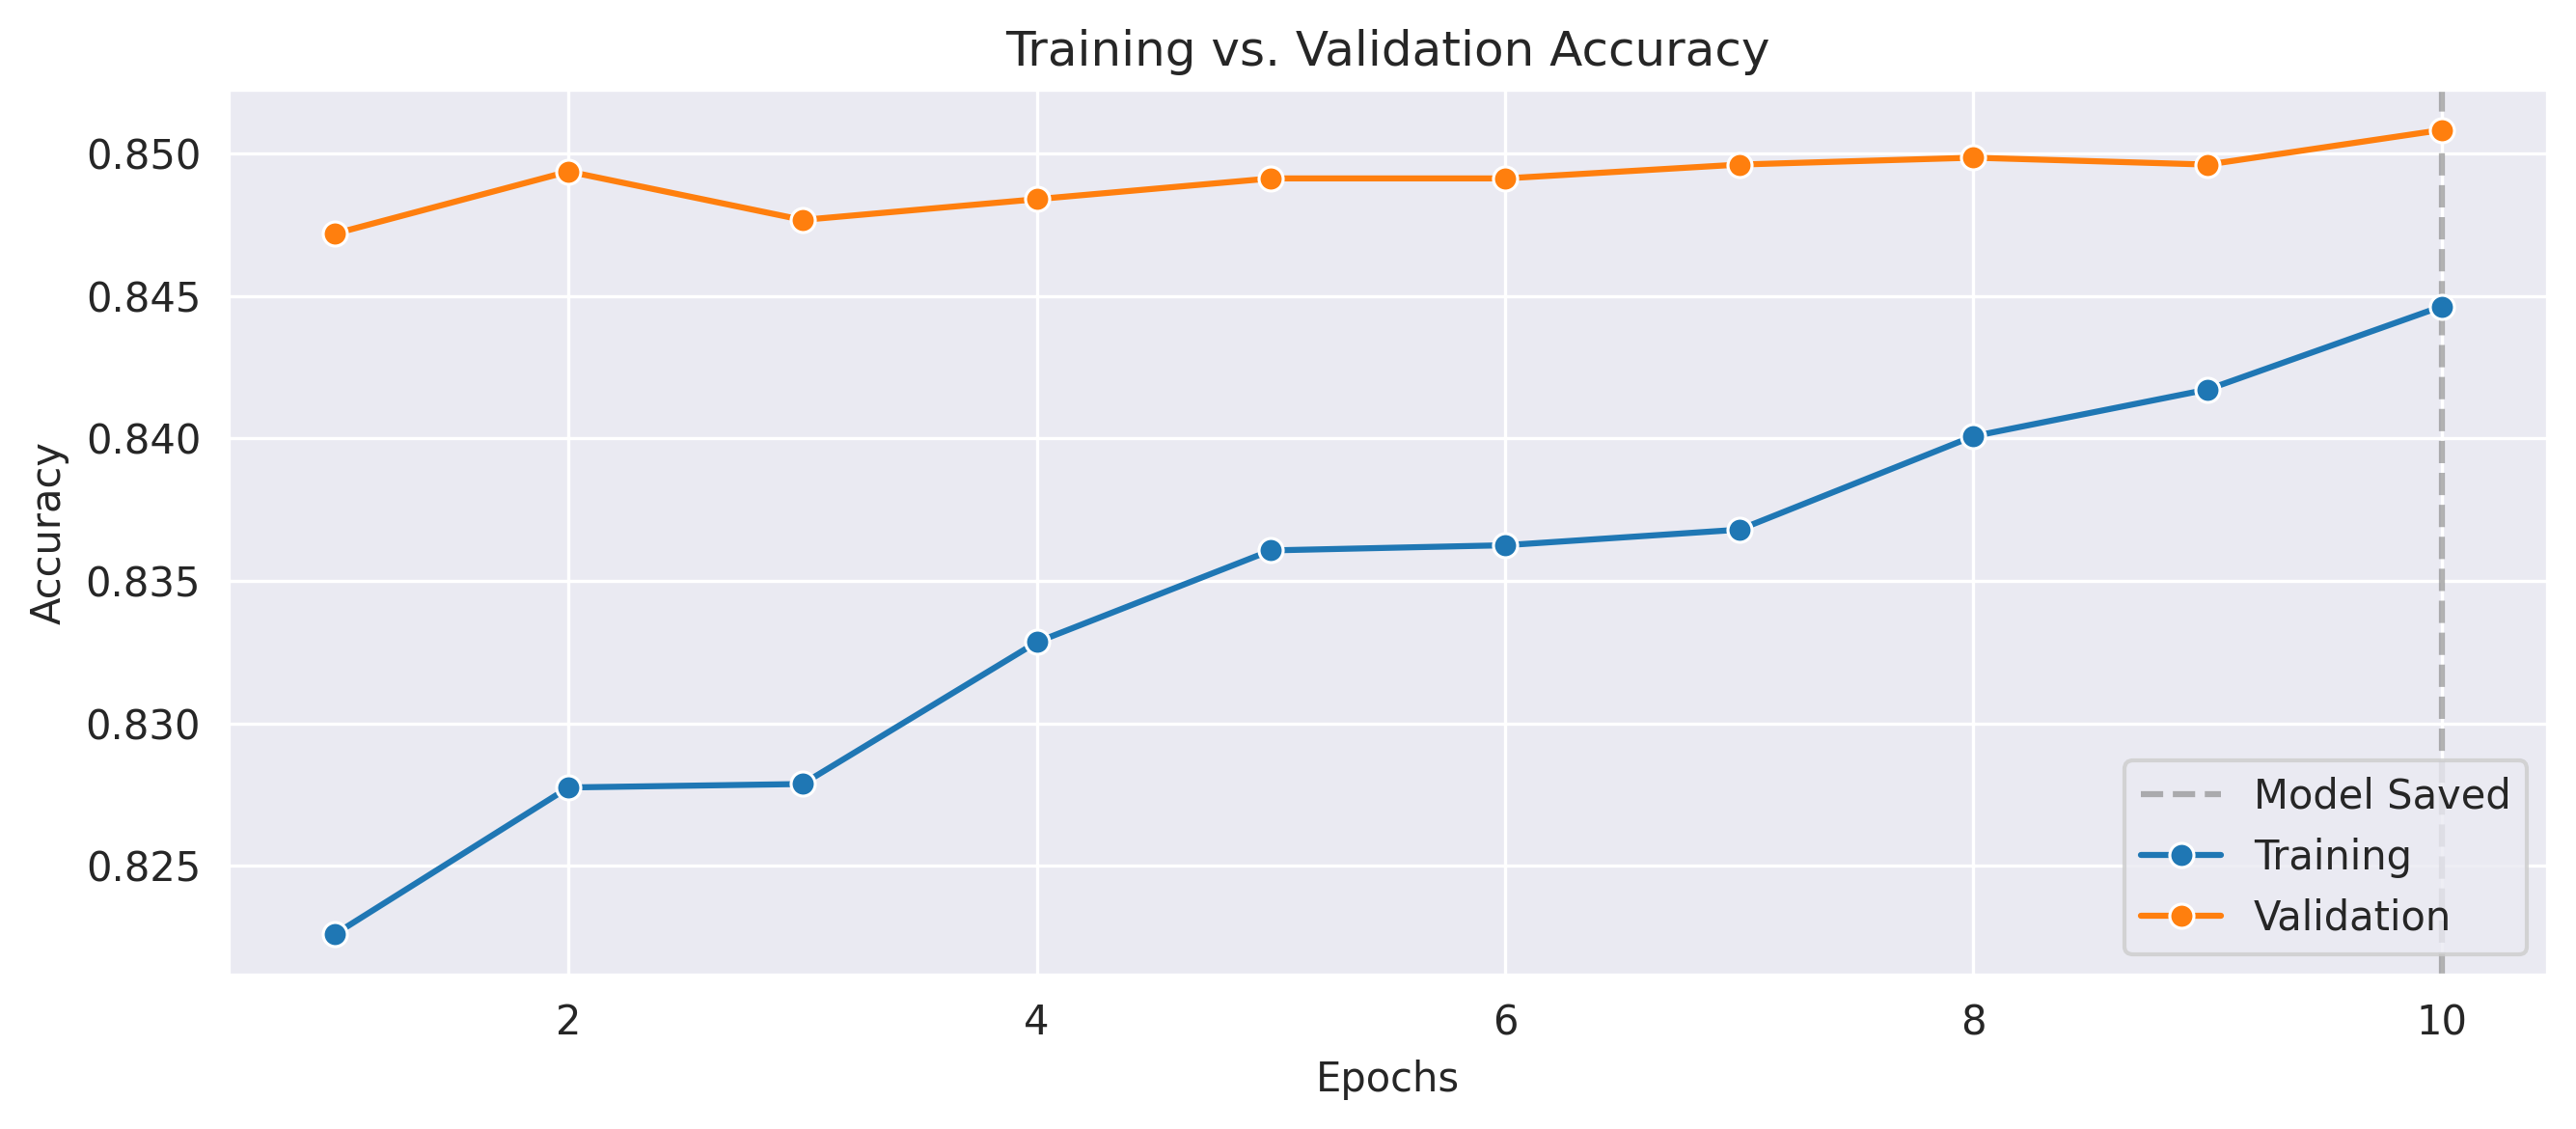

In [ ]:
plot_acc(fine_tuning_history.history, save_epoch=10, save_path=plot_path)

In [ ]:
!ls "/content/drive/MyDrive/Machine Learning Projects/Dog Breed classification project"

 dataset_generator.ipynb
'Dog Breed Classification Project - Yuval Savariego Lasdesman.ipynb'
'model_ft_results(layers=100, lr=1e-06).keras'
'model_ft_results(layers=100, lr=5e-06).keras'
'model_ft_results(layers=30, lr=1e-05).keras'
'model_ft_results(layers=30, lr=1e-06).keras'
'model_ft_results(layers=50, lr=1e-05).keras'
'model_ft_results(layers=50, lr=1e-06).keras'
'model_ft_results(layers=50, lr=5e-06).keras'
'model_ft_results(layers=75, lr=1e-06).keras'
'model_ft_results(layers=75, lr=1e-06)v2.keras'
'model_ft_results(layers=75, lr=5e-06).keras'
 model_rs_results.weights.h5
'training_val_accuracy(layers=100, lr=1e-06).png'
'training_val_accuracy(layers=100, lr=5e-06).png'
'training_val_accuracy(layers=30, lr=1e-05).png'
'training_val_accuracy(layers=30, lr=1e-06).png'
'training_val_accuracy(layers=50, lr=1e-05).png'
'training_val_accuracy(layers=50, lr=1e-06).png'
'training_val_accuracy(layers=50, lr=5e-06).png'
'training_val_accuracy(layers=75, lr=1e-06).png'
'training_val_accur

In [ ]:
# dont run more than once!
concat_versions_hist = {k : [] for k in fine_tuning_history.history.keys()}

for key in concat_versions_hist.keys():
  concat_versions_hist[key].extend(fine_tuning_history.history[key])

In [ ]:
ver = 1

In [ ]:
batch_size = 64
epochs = 4
lr = 1e-06

In [ ]:
train_ds = make_dataset(train_df, batch_size, num_classes, training=True)
val_ds = make_dataset(val_df,   batch_size, num_classes, training=False)

steps_per_epoch = math.ceil(len(train_df) / batch_size)
validation_steps = math.ceil(len(val_df) / batch_size)

In [ ]:
inceptionresnet = load_model(HOME_PATH + log_name)

for layer in inceptionresnet.layers[-trainable_layers:]:
  layer.trainable = True

inceptionresnet.compile(
  optimizer=Adam(learning_rate=lr),
  loss=CategoricalCrossentropy(label_smoothing=0.05),
  metrics=['accuracy']
)

print(f'Unfrozen Layers (top) = {trainable_layers}')
print('-'*30)

fine_tuning_history = inceptionresnet.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[early_stop]
)

ans = str(input('save this model [y/n]: '))
if ans == 'y':
  ver += 1
  for key in concat_versions_hist.keys():
    concat_versions_hist[key].extend(fine_tuning_history.history[key])

  inceptionresnet.save(HOME_PATH + log_name + f'v{ver}')
  print('Saved: ' + log_name + f'v{ver}')
else:
  tf.keras.backend.clear_session()

Unfrozen Layers (top) = 75
------------------------------
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 104 variables whereas the saved optimizer has 108 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 113s 243ms/step - accuracy: 0.8507 - loss: 1.1200 - val_accuracy: 0.8511 - val_loss: 1.0749
Epoch 2/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8467 - loss: 1.1243 - val_accuracy: 0.8511 - val_loss: 1.0744
Epoch 3/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8469 - loss: 1.1357 - val_accuracy: 0.8513 - val_loss: 1.0736
Epoch 4/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8508 - loss: 1.1252 - val_accuracy: 0.8513 - val_loss: 1.0741
Restoring model weights from the end of the best epoch: 3.
save this model [y/n]: y


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Machine Learning Projects/Dog Breed classification project/model_ft_results(layers=75, lr=1e-06).kerasv2.

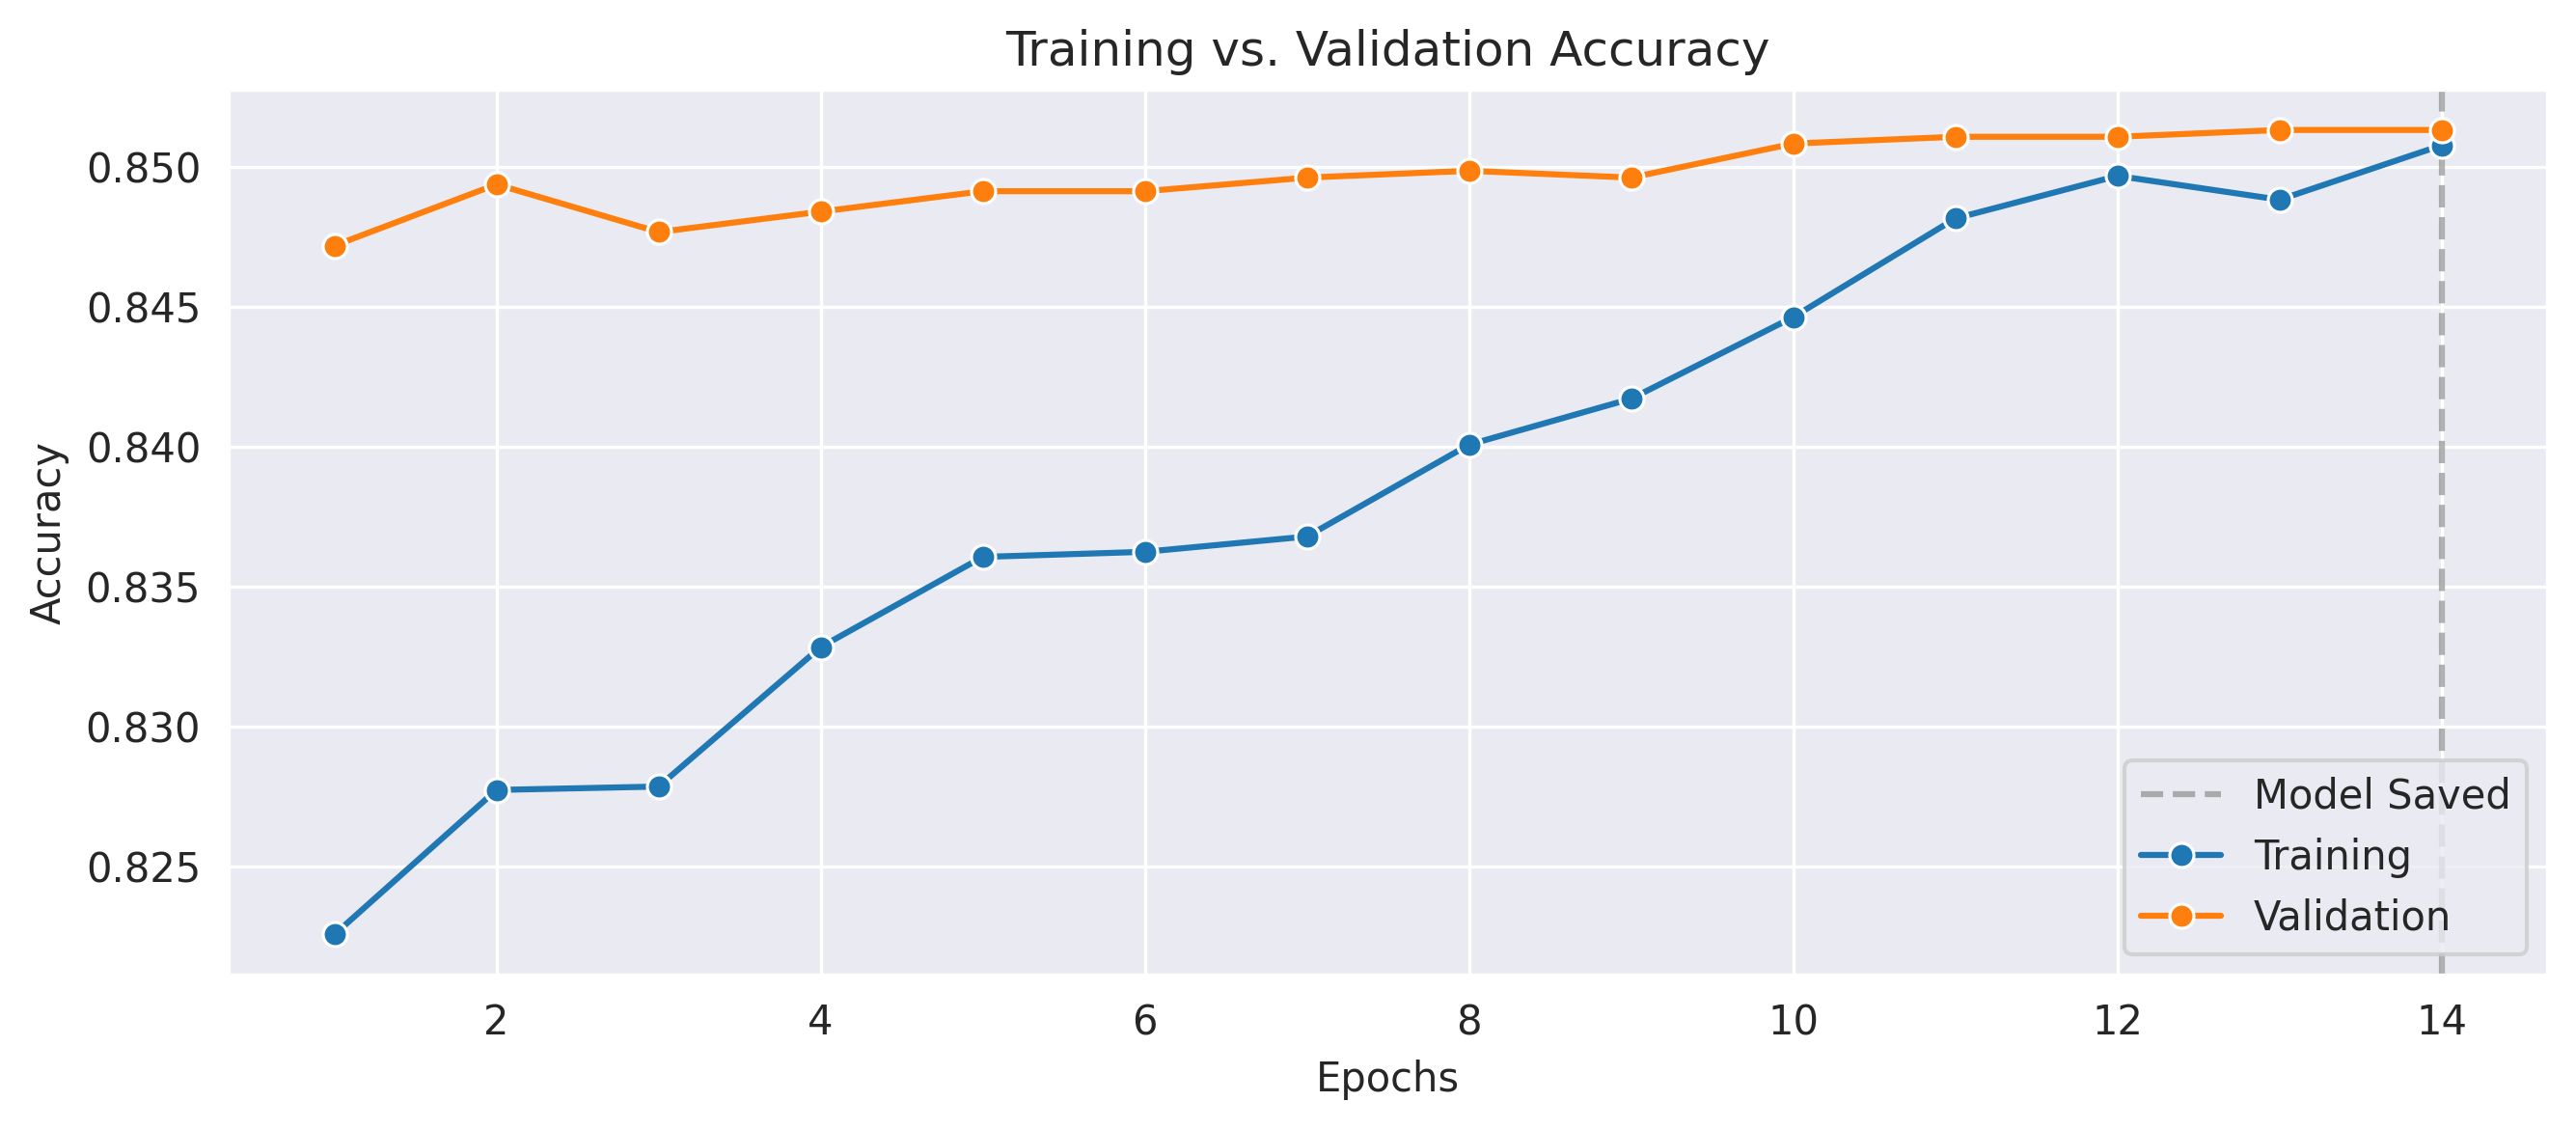

In [ ]:
plot_acc(concat_versions_hist, save_epoch=14, save_path=new_path)

In [ ]:
new_path = HOME_PATH + log_name + f'v{ver}'

In [ ]:
new_path = "/content/drive/MyDrive/Machine Learning Projects/Dog Breed classification project/model_ft_results(layers=75, lr=1e-06)v2.png"

In [ ]:
inceptionresnet.save(new_path)